## Contour deformation 

In the context of GW method, contour deformation (CD) technique is used in conjunction with resolution of identity (RI) to reduce the formal scaling of the self-energy calculation. Compared to widely used analytic continuation approach it provides a means to evaluate self-energy  directly on the real axis without employing Pade approximants or non-linear least squares fit and potentially offering superior accuracy. Here, we provide a brief outline of the theory behind CD and give an example of the self-energy calculation within CD without invoking RI in order to facilitate comparison with the results prsented above. 

Detailed discussion of the CD can be found in the following papers:

1. Golze, D., Wilhelm, J., van Setten, M. J., & Rinke, P. (2018). Core-Level Binding Energies from GW : An Efficient Full-Frequency Approach within a Localized Basis. Journal of Chemical Theory and Computation, 14(9), 4856–4869. https://doi.org/10.1021/acs.jctc.8b00458

2. Giantomassi, M., Stankovski, M., Shaltaf, R., Grüning, M., Bruneval, F., Rinke, P., & Rignanese, G.-M. (2011). Electronic properties of interfaces and defects from many-body perturbation theory: Recent developments and applications. Physica Status Solidi (B), 248(2), 275–289. https://doi.org/10.1002/pssb.201046094

CD is used to recast the convolution in the GW expression of self-energy as a difference between two integrals, one which can be performed analytically whereas the other can be evaluated numerically on a relatively small grid. This is achieved by closing the inegration contour as shown below [2]:

![Integration contour used to evaluate $\Sigma(\omega)$](CD_scheme.jpg)

$$
\Sigma(r_1,r_2, \omega) = \frac{i}{2\pi} \int_{-\infty}^{+\infty} e^{i\omega^{\prime} \eta} G(r_1, r_2, \omega + \omega^{\prime}) W(r_1, r_2, \omega^{\prime}) d\omega^{\prime}\\ 
= \frac{i}{2\pi} \oint_{\Gamma} G(r_1, r_2, \omega + z) W(r_1, r_2, z) dz -  \frac{1}{2\pi} \int_{-\infty}^{+\infty} G(r_1, r_2, \omega + i\omega^{\prime}) W(r_1, r_2, i\omega^{\prime}) d\omega^{\prime}
$$

Depending on the $\omega$ value the lower-left and the upper-right loops of the contour can enclose one or several poles of the zero-order Green's function whereas the poles of the screened Coulomb interaction never fall within the contour. This allowes to evaluate the countour integral as a sum of corresponding residues with apropriate signs (note that the upper-right loop is traversed counter-clockwise, while the lower-left loop is traversed clockwise). The imaginary axis contribution is calculated using Gauss-Legendre grid. Importantly, the intgrals over the arches vanish iff the screened Coulomb interaction does not contain the exchange contribution.

In [2]:
import psi4
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
psi4.set_options({'basis' : 'aug-cc-pvtz', 'd_convergence' : 1e-7,'scf_type' : 'out_of_core' })
h2o = psi4.geometry("""O   0.000000000000  -0.143225816552   0.000000000000 
                       H   1.638036840407   1.136548822547  -0.000000000000
                       H  -1.638036840407   1.136548822547  -0.000000000000
                       symmetry c1
                       units bohr
""")

#psi4.set_options({'basis': 'aug-cc-pvdz'})
#psi4.set_options({'basis': 'cc-pvdz'})

#psi4.set_memory('2 GB')
psi4.set_output_file('h2o_accpvtz.out')

# Get the SCF wavefunction & energies
scf_e, scf_wfn = psi4.energy('hf', return_wfn=True)
#scf_e = psi4.energy('hf')

print("SCF energy is %16.10f" % scf_e)


SCF energy is   -76.0216331405


In [4]:
# GW implementation will be folded into a standalone class that uses molecule and wave function data from Psi4

class GW:
    
    def __init__(self, wfn, mol, gw_par):
        
        # wfn - Psi4 w.f. object from SCF calculation
        # mol - Psi4 molecule object
        # gw_par - is a dictionary with GW calculation parameters
        #          such as the number of states or the number of 
        #          omega sampling points
        
        self.scf_wfn = wfn
        self.mol = mol
        self.gw_par = gw_par
        
        
        self._init_sys_params() # sets some basic system parameters
        
        # Determine if we are doing RI
        
        self.do_ri = True if not 'do_ri' in gw_par.keys() else gw_par['do_ri']
        
        if self.do_ri:
            self._gen_ri_ints()     # generates integrals for RI-GW and
            # RI integrals are now available in self.nmR
        else:
            self._transform_eri()
            
        # Generate modified Gauss-Legendre grid for the frequency integration on imaginary axis
        
        self.gl_npoint =  100 if not 'gl_npoint' in gw_par.keys() else gw_par['gl_npoint']
        self._gen_gaussleg()
            
        # set GW calculation parameters
        
        # parameters of the self-energy calculation
        nomega_sigma =  501 if not 'nomega_sigma' in gw_par.keys() else gw_par['nomega_sigma']
        step_sigma = 0.01 if not 'step_sigma' in gw_par.keys() else  gw_par['step_sigma']
        
        # Quasi-particle states 
        self.no_qp = self.nocc if not 'no_qp' in gw_par.keys() else gw_par['no_qp'] # Number of hole states 
        self.nv_qp = 0 if not 'nv_qp' in gw_par.keys() else gw_par['nv_qp']             # Number of particle states
        self.eta = 1e-3  # Default eta value as recommended by F. Bruneval
        self.do_cd = True if not 'do_cd' in gw_par.keys() else gw_par['do_cd']
        
        
        # Quick sanity check
        
        assert self.no_qp <= self.nocc and self.nv_qp <= self.nvir
        
        # ### GW calculation starts here ### 
        
        # Evaluate screened Coulomb interaction
        
        self._calculate_W(gw_par)

        # create an array of sampling frequencies similar to MolGW

        nomega_grid = nomega_sigma // 2 # note this is a truncation (aka integer) division
        omega_grid = np.array(range(-nomega_grid, nomega_grid + 1)) * step_sigma
        
        
        # sampling energies for all the states so we could calculate the self-energy matrix (broadcasting)

        omega_grid_all = omega_grid + self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp].reshape((-1, 1))
        assert omega_grid_all.shape == (self.no_qp + self.nv_qp, 2*nomega_grid + 1)
        print("Shape of the omega_grid_all is ", omega_grid_all.shape)
        self.omega_grid_all = np.copy(omega_grid_all)
        
        method = 'spectral decomposition' if not self.do_cd else 'contour deformation'
        print("Caculating GW self-energy %s" % (method))
        
        Sigma_c_grid = self._calculate_iGW(omega_grid_all) # self-energy matrix
        self.Sigma_c_grid = np.copy(Sigma_c_grid)
            
        # Apply solvers; Similar to MolGW - linear & graphic solutions

        print("Performing one-shot G0W0")
        
        qp_molgw_lin_ = np.zeros(self.no_qp + self.nv_qp)

        # Calculate pole strengths by performing numerical derivative on the omega grid

        zz = np.real(Sigma_c_grid[:, nomega_grid + 1] - Sigma_c_grid[:, nomega_grid - 1]) / (omega_grid[nomega_grid + 1] - omega_grid[nomega_grid - 1])
        zz = 1. / (1. - zz)
        zz[zz <= 0.0] = 0.0
        zz[zz >= 1.0] = 1.0
        
        qp_molgw_lin_ = self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp] + zz * np.real(Sigma_c_grid[:, nomega_grid])
        
        print("Perfoming graphic solution of the inverse Dyson equation")

        # both rhs and lhs of the QP equation have been calculated above
        
        qp_molgw_graph_ = np.copy(self.eps[self.nocc - self.no_qp:self.nocc + self.nv_qp])
        zz_graph = np.zeros(self.no_qp + self.nv_qp)
        
        for state in range(self.no_qp + self.nv_qp):
            z , e = self._find_fixed_point(omega_grid_all[state], np.real(Sigma_c_grid[state, :]) + self.eps[state + self.nocc - self.no_qp])
            if z[0] < 1e-6:
                print("Graphical solver failed for state %d" % (state + 1))
            # Do nothing since the array cell already contains HF orbital energy
            else:
                qp_molgw_graph_[state] = e[0]
                zz_graph[state] = z[0]
                
        self.zz = np.copy(zz)
        self.qp_molgw_lin_ = np.copy(qp_molgw_lin_)
        self.qp_molgw_graph_ = np.copy(qp_molgw_graph_)
                
        print("Done!")
        
    def print_summary(self):
        
        Ha2eV = 27.21138505
        
        print("E^lin, eV  E^graph, eV  Z ")
        for i in range(self.no_qp + self.nv_qp):
            print("%13.6f  %13.6f  %13.6f" % (self.qp_molgw_lin_[i]*Ha2eV, self.qp_molgw_graph_[i]*Ha2eV, self.zz[i]))
    
                
    def _init_sys_params(self):
        
        self.nocc = self.scf_wfn.nalpha()
        self.nbf = self.scf_wfn.nmo()
        self.nvir = self.nbf - self.nocc
        self.C = self.scf_wfn.Ca()
        
        self.Cocc = self.scf_wfn.Ca_subset("AO", "OCC")
        self.Cvirt = self.scf_wfn.Ca_subset("AO", "VIR")
        
        self.eps = np.asarray(self.scf_wfn.epsilon_a())
        
        # print a quick summary
        print("Number of basis functions: ", self.nbf)
        print("occ/virt: %d/%d" % (self.nocc, self.nvir))
    
    def _transform_eri(self):
        
        Co = self.Cocc
        C = self.C
        
        mints = psi4.core.MintsHelper(self.scf_wfn.basisset())
        self.MO = np.asarray(mints.mo_eri(Co, C, C, C))
        
    def _gen_ri_ints(self):
        
        # MO coefficients
        C = np.asarray(self.C)
        
        # Extract basis set from the wfn object
        orb = self.scf_wfn.basisset()
        
        # Build auxiliary basis set
        #aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "JKFIT", orb.name())
        aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "RIFIT", orb.name())
        #aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "RIFIT", "aug-cc-pVTZ")
        #aux = psi4.core.BasisSet.build(self.mol, "DF_BASIS_SCF", "", "JKFIT", "aug-cc-pVTZ")
        
        
        # From Psi4 doc as of March, 2019 (http://www.psicode.org/psi4manual/1.2/psi4api.html#psi4.core.BasisSet.zero_ao_basis_set): 
        # Returns a BasisSet object that actually has a single s-function at 
        # the origin with an exponent of 0.0 and contraction of 1.0.
        zero_bas = psi4.core.BasisSet.zero_ao_basis_set()
        
        # Create a MintsHelper Instance
        mints = psi4.core.MintsHelper(orb)

        # Build (pq|P) raw 3-index ERIs, dimension (nbf, nbf, Naux, 1)
        pqP = mints.ao_eri(orb, orb, aux, zero_bas)

        # Build and invert the metric
        metric = mints.ao_eri(zero_bas, aux, zero_bas, aux)
        metric.power(-0.5, 1.e-14)
        
        # Remove the dimensions of size 1
        pqP = np.squeeze(pqP)
        metric = np.squeeze(metric)

        # Transform (pq|P) to obtain (nm|P) in molecular orbital basis
        nmP = np.einsum("pn, qm, pqR-> nmR", C, C, pqP)
        
        # Contract with the inverse square root of the metric tensor
        self.nmR = np.einsum( "nmP, PR-> nmR", nmP, metric)
        
        print("Auxiliary basis set has been generated!")
        print("Number of auxiliary basis functions: ", self.nmR.shape[2])
        
    def _gen_gaussleg(self):
        
        x, w = np.polynomial.legendre.leggauss(self.gl_npoint)
        self.gl_x = (1. + x) / (1. - x)
        self.gl_w = 2. * w / (1. - x)**2
        
        
    def _find_fixed_point(self, lhs, rhs):
        # This function returns an array of fixed points and correspoinding pole strengths
        # Its application can be vectorized using strandard NumPy np.vectorize
    
        assert lhs.shape == rhs.shape
    
        # Maximum number of fixed points (same as in MolGW)
        nfp_max = 4
    
        # Pole strength threshold
        pthresh = 1e-5
    
        # Arrays of f.p. energies and  Z
        zfp = np.zeros(nfp_max)
        zfp[:] = -1.0
        efp = np.zeros(nfp_max)
    
        # Auxiliary index array
        idx = np.arange(nfp_max)
    
        n = len(lhs)
        ifixed = 0
        g = rhs - lhs
    
        # loop over grid points excluding the last one
    
        for i in range(n - 1):
            if g[i] * g[i + 1] < 0.0:
                #print("Fixed point found betwenn %13.6f and %13.6f eV! " % (lhs[i] * Ha2eV, lhs[i+1] * Ha2eV))
                z_zero = 1. / ( 1. - ( g[i+1] - g[i] ) / ( lhs[i+1] - lhs[i] ) )
                if z_zero < pthresh:
                    continue
                # Do some bookkeeping; the code looks ugly but that is exactly what F.Bruneval has in MolGW package
            
                if z_zero > zfp[-1]:
                    jfixed = np.min(idx[z_zero > zfp])
                    zfp[jfixed + 1:] = zfp[jfixed:nfp_max - 1]
                    efp[jfixed + 1:] = efp[jfixed:nfp_max - 1]
                    zfp[jfixed] = z_zero
                    # Perfom linear interpolation to find the root
                    zeta = (g[i + 1] - g[i]) / (lhs[i + 1] - lhs[i])
                    efp[jfixed] = lhs[i] - g[i] / zeta
    
        #print("Graphical solver concluded operation")
        return (zfp, efp)
    
    def _calculate_W(self, gw_par):
        
                
        nocc = self.nocc
        nvir = self.nvir
        
        # Diagonal \epsilon_a - \epsilon_i
        eps_diag = self.eps[nocc:].reshape(-1, 1) - self.eps[:nocc]
        assert eps_diag.shape == (nvir, nocc)
        
        # A^{+} + B^{+}
        ApB = np.zeros((nocc, nvir, nocc, nvir))
        if self.do_ri:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * np.einsum("iaQ, jbQ->iajb", self.nmR[:nocc, nocc:], self.nmR[:nocc, nocc:])
        else:
            ApB = np.einsum("ij,ab,ai -> iajb", np.eye(nocc), np.eye(nvir), eps_diag) + 4. * self.MO[:nocc, nocc:, :nocc, nocc: ]
        
                  
        
        ApB = ApB.reshape((nocc*nvir, nocc*nvir)) 
        # since nD numpy arrays have C-style memroy layout the occupied orbital inedex changes slower than the virtual one

        # Diagonal of  A^{+} - B^{+}
        AmB_diag = eps_diag.T.reshape((1, -1))
        AmB_diag = np.diag(AmB_diag[0,:])

        assert AmB_diag.shape == ApB.shape

        # Form C matrix (as one usually does when solving RPA eigenvalue problem)
        C_ = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), ApB, np.sqrt(AmB_diag))
        
        # Solve for the excitation energies and calculate X + Y eigenvectors
        
        omega2, Z = np.linalg.eigh(C_)
        self.omega_s = np.sqrt(omega2)
        self.xpy = np.einsum("ij,jk,kl->il", np.sqrt(AmB_diag), Z, np.diag(1./np.sqrt(self.omega_s)))
        
    def _calculate_iGW(self, omega_grid_all):
        
        nocc = self.nocc
        nvir = self.nvir
        eps = self.eps
        
        no_qp = self.no_qp
        nv_qp = self.nv_qp
        nbf = self.nbf
        
        e_fermi = (eps[nocc - 1] + eps[nocc]) / 2.
        ngrid = omega_grid_all.shape[1]
        
        assert omega_grid_all.shape == (no_qp + nv_qp, ngrid)
        
        # Self-energy denominators; those are of two kinds

        Dis = -eps[:nocc].reshape((-1, 1)) + self.omega_s
        Das = -eps[nocc:].reshape((-1, 1)) - self.omega_s 
        
        # Omega tensors; This will be refactored to improve memory efficiency
        i_rtia = np.zeros((nbf,nbf, nocc, nvir))
        if self.do_ri:
            i_rtia = np.einsum("iaQ, rtQ ->rtia", self.nmR[:nocc, nocc:, :], self.nmR) 
            i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))
        else:
            i_rtia = np.einsum("iart->rtia", self.MO[:nocc,nocc:,:,:]) 
            i_rtia = i_rtia.reshape((nbf, nbf, nocc*nvir))
            
        omega_rts = np.sqrt(2.) * np.einsum("rtk, ks->rts", i_rtia, self.xpy)
        print("Shape of omega is ", omega_rts.shape)
        
        # The rest depends on the particular algorithm requested by the user
        
        if self.do_cd:
            e_ai = eps[nocc:, np.newaxis] - eps[np.newaxis, :nocc]
            im_grid = self.gl_x * 1.j
            Ds_p = self.omega_s.reshape((-1, 1)) + im_grid  - 0.5j*self.eta
            Ds_m = -self.omega_s.reshape((-1, 1)) + im_grid  + 0.5j*self.eta
            
            assert Ds_p.shape == Ds_m.shape and Ds_m.shape == (len(self.omega_s), len(self.gl_x))
            
            # Calculate some intermediates for the imaginary time integration
            f = np.ones(nbf)
            f[eps > e_fermi] = -1.
            assert np.sum(f) == nocc - nvir
            complex_eps = eps + 0.5j * self.eta * f
            
            # Calculate Wnm on the imaginary frequency grid
            Wnm_im_grid = np.einsum("nms, sg, nms -> nmg",omega_rts[nocc - no_qp:nocc + nv_qp,:,:], 1./Ds_m - 1./Ds_p, omega_rts[nocc - no_qp:nocc + nv_qp,:,:])
            #print(Wnm_im_grid.shape)
            #print( (no_qp + nv_qp, nbf, len(self.gl_x)) )
            assert Wnm_im_grid.shape == (no_qp + nv_qp, nbf, len(self.gl_x)) 
            
            # ### GW self-energy calculation via contour deformation
            In = np.zeros(omega_grid_all.shape, dtype=np.complex128) # Integral term
            Rn = np.zeros(omega_grid_all.shape, dtype=np.complex128) # Residue term
            
            # Integral term
            for qp in range(no_qp + nv_qp):
                # Calculate GF denominators = omega + 1.j omega_prime - eps_m \pm i eta
                qp_grid = np.copy(omega_grid_all[qp, :])
                
                Dgf_p = qp_grid[:, np.newaxis, np.newaxis]  - complex_eps[np.newaxis, :, np.newaxis] + im_grid[np.newaxis,np.newaxis, :]
                Dgf_m = qp_grid[:, np.newaxis, np.newaxis]  - complex_eps[np.newaxis, :, np.newaxis] - im_grid[np.newaxis,np.newaxis, :]
                assert Dgf_p.shape == (ngrid, nbf, len(self.gl_x)) and Dgf_m.shape == (ngrid, nbf, len(self.gl_x))
                Wnm_tmp = np.copy(Wnm_im_grid[qp,:,:])
                I_term = 1. / (2.*np.pi) * np.einsum("fmg, g->f", Wnm_tmp[np.newaxis, :,:]* (1./ Dgf_p + 1./Dgf_m), self.gl_w)
                In[qp, :] = np.copy(I_term)
                
                # Residue term
                # Caculate Wnm and f vector for a give quasi-particle
                # Not memory efficient; just for testing
                
                offset_complex_eps = complex_eps[:, np.newaxis] - qp_grid
                assert offset_complex_eps.shape == (nbf, ngrid)
                
                Ds_p__ = offset_complex_eps[:,:,np.newaxis] + self.omega_s[np.newaxis, np.newaxis,:] - 0.5j*self.eta
                Ds_m__ = offset_complex_eps[:,:,np.newaxis] - self.omega_s[np.newaxis, np.newaxis,:] + 0.5j*self.eta
                
                assert Ds_p__.shape == Ds_m__.shape and Ds_p__.shape == (nbf, ngrid, len(self.omega_s))
                
                Wnm_4res = np.einsum("ms, ms, mgs  -> mg",omega_rts[nocc - no_qp + qp,:,:], omega_rts[nocc - no_qp + qp,:,:], 1./Ds_m__ - 1./Ds_p__)
                # Should I handle this with plain loops?
                
                fill_factors = np.zeros((ngrid, nbf))
                #mask_vir = np.logical_and(qp_grid[:,np.newaxis] > eps[np.newaxis, :], eps.reshape((1, -1)) > e_fermi)
                #mask_occ = np.logical_and(qp_grid[:,np.newaxis] < eps[np.newaxis, :], eps.reshape((1, -1)) < e_fermi)
                # This is still incorrect but should be a bit better
                mask_vir = np.logical_and(qp_grid[:,np.newaxis] > eps[np.newaxis, :], eps.reshape((1, -1)) > e_fermi)
                mask_occ = np.logical_and(qp_grid[:,np.newaxis] < eps[np.newaxis, :], eps.reshape((1, -1)) < e_fermi)
                fill_factors[mask_vir] = 1.
                fill_factors[mask_occ] = -1.
                
                # Treat a special case
                mask_vir_eq = np.logical_and(qp_grid[:,np.newaxis] == eps[np.newaxis, :], eps.reshape((1, -1)) > e_fermi)
                mask_occ_eq = np.logical_and(qp_grid[:,np.newaxis] == eps[np.newaxis, :], eps.reshape((1, -1)) < e_fermi)
                
                fill_factors[mask_vir_eq] = 0.5
                fill_factors[mask_occ_eq] = -0.5
                
                R_term = np.einsum("gm, mg->g", fill_factors, Wnm_4res)
                Rn[qp, :] = np.copy(R_term)
                
                #quick sanity check for the residue term
                within_gap = np.logical_and(qp_grid < eps[nocc], qp_grid > eps[nocc - 1])
                #print("R term within the HOMO-LUMO gap ", R_term[within_gap])
            
            return Rn - In   
            
          
        else:
            #Calculate denominators
            
            Dis_ = Dis + omega_grid_all.reshape((no_qp + nv_qp, omega_grid_all.shape[1], 1, 1)) - 1.j*self.eta
            Das_ = Das + omega_grid_all.reshape((no_qp + nv_qp, omega_grid_all.shape[1], 1, 1)) + 1.j*self.eta

            # self-energy matrix (with the shape (no_qp + nv_qp, 2*nomega_grid + 1))
            
            # Contribution due to occupied orbitals (note that the shape of the structure of the denominator array is not optimal)
            Sigma_c_grid = np.einsum("kis, klis, kis->kl", omega_rts[nocc - no_qp:nocc + nv_qp,:nocc,:], 1./Dis_, omega_rts[nocc - no_qp:nocc + nv_qp,:nocc,:])
            # Contribution due to virtuals
            Sigma_c_grid +=  np.einsum("kas, klas, kas->kl", omega_rts[nocc - no_qp:nocc + nv_qp,nocc:,:], 1./Das_, omega_rts[nocc - no_qp:nocc + nv_qp,nocc:,:])
            
            return Sigma_c_grid
        


In [5]:
# Test case
gw_par = {'no_qp' : 5, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : False, 'do_cd' : False} 

gw_h2o_ccpvdz = GW(scf_wfn, h2o, gw_par)
gw_h2o_ccpvdz.print_summary()

Number of basis functions:  92
occ/virt: 5/87
Shape of the omega_grid_all is  (5, 501)
Caculating GW self-energy spectral decomposition
Shape of omega is  (92, 92, 435)
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
  -546.392837    -545.685334       0.796623
   -31.479951     -31.340460       0.813362
   -17.446827     -17.446783       0.936481
   -14.550474     -14.549834       0.927209
   -12.452728     -12.450232       0.920234


In [7]:
del gw_h2o_ccpvdz

In [8]:

gw_par = {'no_qp' : 5, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True, 'do_cd' : False} 
gw_h2o_ccpvdz_ri = GW(scf_wfn, h2o, gw_par)
gw_h2o_ccpvdz_ri.print_summary()

Number of basis functions:  92
occ/virt: 5/87
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  198
Shape of the omega_grid_all is  (5, 501)
Caculating GW self-energy spectral decomposition
Shape of omega is  (92, 92, 435)
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
  -546.392862    -545.685355       0.796622
   -31.480073     -31.340300       0.813267
   -17.446216     -17.446171       0.936483
   -14.550022     -14.549381       0.927211
   -12.452110     -12.449611       0.920236


In [9]:
del gw_h2o_ccpvdz_ri

In [10]:
#del gw_h2o_ccpvdz
#del gw_h2o_ccpvdz_ri

gw_par = {'no_qp' : 5, 'nv_qp' : 0, 'nomega_sigma' : 501, 'step_sigma' : 0.01, 'do_ri' : True, 'do_cd' : True}
gw_h2o_ccpvdz_cd = GW(scf_wfn, h2o, gw_par)
gw_h2o_ccpvdz_cd.print_summary()

Number of basis functions:  92
occ/virt: 5/87
Auxiliary basis set has been generated!
Number of auxiliary basis functions:  198
Shape of the omega_grid_all is  (5, 501)
Caculating GW self-energy contour deformation
Shape of omega is  (92, 92, 435)
Performing one-shot G0W0
Perfoming graphic solution of the inverse Dyson equation
Done!
E^lin, eV  E^graph, eV  Z 
  -546.391236    -545.685355       0.796622
   -31.479622     -31.340300       0.813267
   -17.445912     -17.446022       0.936483
   -14.549623     -14.549381       0.927211
   -12.451620     -12.449611       0.920236


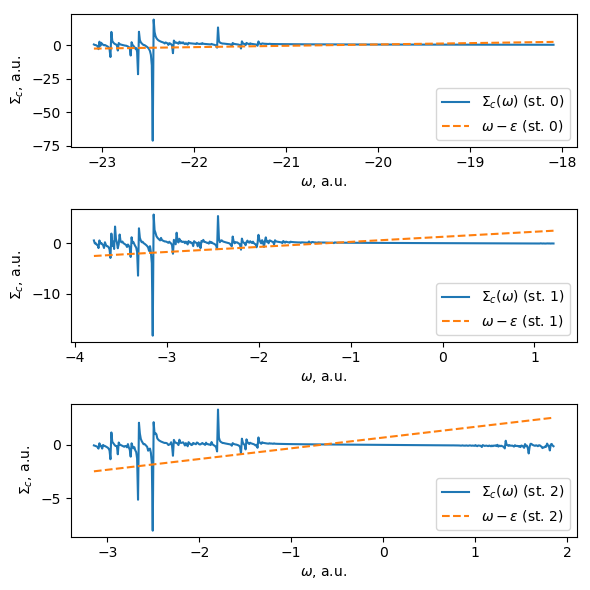

In [11]:
eps = gw_h2o_ccpvdz_cd.eps
nocc = gw_h2o_ccpvdz_cd.nocc
no_qp = gw_h2o_ccpvdz_cd.no_qp
nv_qp = gw_h2o_ccpvdz_cd.nv_qp

fig, axes = plt.subplots(nrows=3, figsize=(6,6), dpi=100)

for state in range(3):
    grid = gw_h2o_ccpvdz_cd.omega_grid_all[state,:]
    sigma = gw_h2o_ccpvdz_cd.Sigma_c_grid[state,:].real
    l = grid - eps[state]
    axes[state].plot(grid, sigma, label = '$\Sigma_c(\omega)$ (st. {0:d})'.format(state))
    axes[state].plot(grid, l, '--', label = '$\omega - \epsilon$ (st. {0:d})'.format(state))
    axes[state].set_xlabel('$\omega$, a.u.')
    axes[state].set_ylabel('$\Sigma_c$, a.u.')
    axes[state].legend()
    
fig.tight_layout()    
    
    





#window = np.logical_and(grid < 0., grid > -1.) # discontinuity
#window = np.logical_and(grid < -21., grid > -23.)
#window = np.logical_and(grid < 100., grid > -100.)
#window = np.logical_and(grid < eps[nocc], grid > eps[nocc - 1])
